# Defense Examples

En este Notebook se exploran las funciones de preprocesamiento como defensa.

## Importaciones

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import cv2

## Datos

In [2]:
testset = torchvision.datasets.CIFAR10(
    root='../data/01_raw', train=False, download=True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified


## Funciones de defensa

In [3]:
def resize_pad(image, ratio=0.8):
    """
    Resizes and pads an image with zeros to match the original size.

    Args:
        image (numpy.ndarray): The input image to resize and pad.
        ratio (float): The ratio to resize the image by (default 0.8).

    Returns:
        torch.Tensor: The resized and padded image.
    """
    original = image.numpy().transpose((1, 2, 0))
    old_size = original.shape[:2]
    new_size = int(old_size[0] * ratio)
    img = cv2.resize(original, (new_size, new_size))
    max_y = old_size[0] - new_size
    max_x = old_size[1] - new_size
    start_y = np.random.randint(0, max_y)
    start_x = np.random.randint(0, max_x)
    pad = np.zeros_like(original)
    pad[start_y:start_y + new_size, start_x:start_x + new_size] = img
    pad = cv2.flip(pad, 1)
    return torch.from_numpy(pad.transpose((2, 0, 1))).float()

In [4]:
def random_distortion(h, w, d, delta):
    """
    Returns distorted coordinates
    """
    nw = w // d
    nh = h // d
    distorted_coords = torch.zeros(nh+1, nw+1, 2)
    
    for m in range(nw+1):
        for n in range(nh+1):
            dx = (torch.rand(1) * 2 - 1) * delta  
            dy = (torch.rand(1) * 2 - 1) * delta 
            x = m * d + dx
            y = n * d + dy
            distorted_coords[n, m, 0] = x
            distorted_coords[n, m, 1] = y
            
    return distorted_coords

In [5]:
def image_distortion(img, d, delta):
    """
    Apply distortion to a given image.
    img: a tensor of shape (C, H, W)
    d: size of the grid
    delta: distortion limit
    """
    C, H, W = img.shape
    nw = W // d
    nh = H // d
    distorted_coords = random_distortion(H, W, d, delta)
    distorted_image = torch.zeros_like(img)
    
    for m in range(nw+1):
        for n in range(nh+1):
            src_x = m * d
            src_y = n * d
            dest_x = int(distorted_coords[n, m, 0].item())
            dest_y = int(distorted_coords[n, m, 1].item())
            for i in range(d+1):
                for j in range(d+1):
                    if src_y + j < H and src_x + i < W and dest_y + j < H and dest_x + i < W:
                        distorted_image[:, dest_y + j, dest_x + i] = img[:, src_y + j, src_x + i]
                        
    return distorted_image

## Visualizando las defensas

In [6]:
attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet'] #,Regnet_x','Regnet_y']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
model = catalog.load(f"Resnet_model")

[10/16/23 19:56:06] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=951487;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=877504;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py#492\492]8;;\

Write a number 1000


[10/16/23 20:12:42] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=383808;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=216791;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

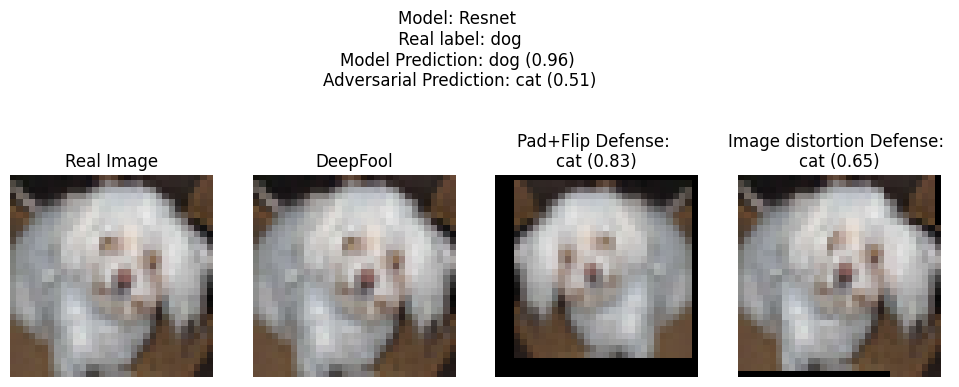

[10/16/23 20:12:43] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=573081;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=595699;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

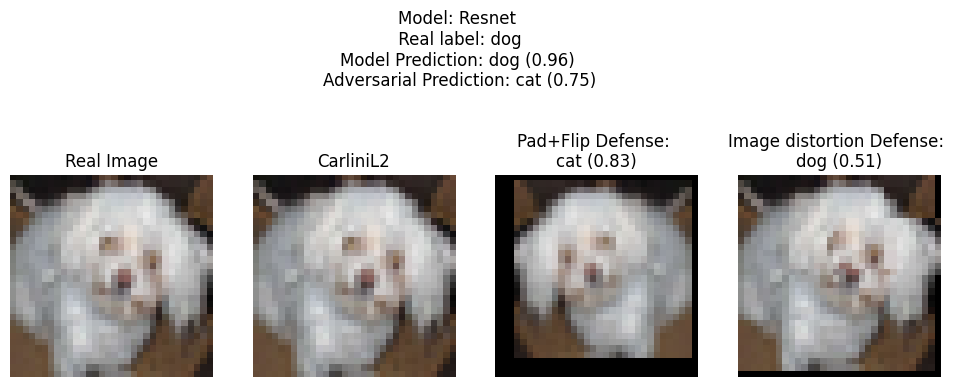

                    INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=645257;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=193188;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

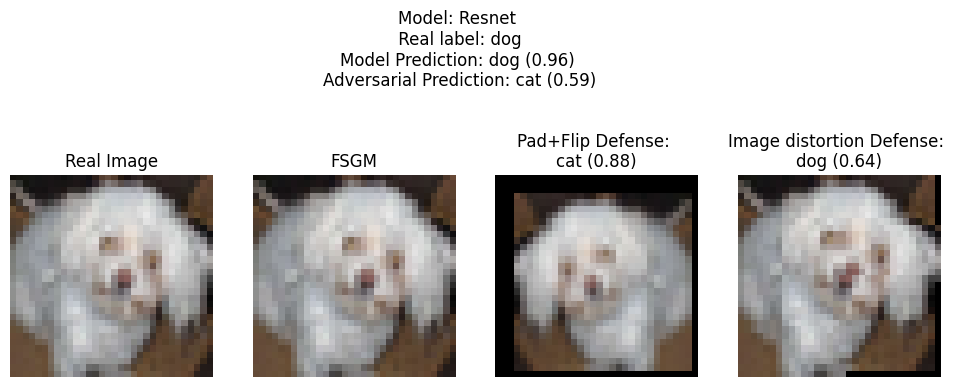

                    INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=62855;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=720753;file:///opt/homebrew/Caskroom/miniconda/base/envs/adverfull/lib/python3.11/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

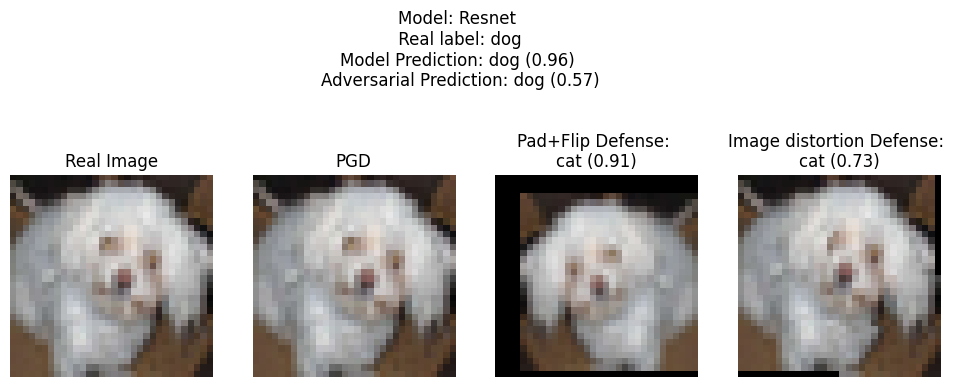

In [24]:
number = int(input('Write a number'))

for _, attack in it.product(models, attacks):
    adver = catalog.load(f'Resnet_model_Adversarial_{attack}@Dataset')
    adver_im = adver['examples'][number]
    title = str(f"Model: Resnet \n Real label: {testset.classes[adver['real_labels'][number]]} \n" + 
                f"Model Prediction: {testset.classes[adver['model_labels'][number]]} ({adver['confidence'][number]:.2f}) \n" +
                f"Adversarial Prediction: {testset.classes[adver['adversarial_labels'][number]]} ({adver['adversarial_confidence'][number]:.2f})")
    
    # Defense
    pad_def = resize_pad(adver_im, 0.9)
    dist_def = image_distortion(adver_im, 8, 0.3)
    
    # Predictions
    with torch.no_grad():
        pad_pred, class_pad = torch.max(torch.softmax(model(pad_def.unsqueeze(0)), dim=1), dim=1)
        dist_pred, class_dist = torch.max(torch.softmax(model(dist_def.unsqueeze(0)), dim=1), dim=1)
    
    # Plot results
    fig, ax = plt.subplots(1, 4, figsize = (12, 5.5))
    ax[0].imshow(testset[number][0])
    ax[0].set_title("Real Image")
    ax[0].axis("off")
    ax[1].imshow(adver_im.numpy().transpose((1, 2, 0)))
    ax[1].set_title(f"{attack}")
    ax[1].axis("off")
    ax[2].imshow(pad_def.numpy().transpose((1, 2, 0)))
    ax[2].set_title("Pad+Flip Defense: \n" + f"{classes[class_pad]} ({pad_pred[0]:.2f})")
    ax[2].axis("off")
    ax[3].imshow(dist_def.numpy().transpose((1, 2, 0)))
    ax[3].set_title("Image distortion Defense: \n" + f"{classes[class_dist]} ({dist_pred[0]:.2f})")
    ax[3].axis("off")
    plt.suptitle(title)
    plt.show()